# Visualizing the latent space of the decoder

#### Intermediate summary (04/07/19) 

The input to the decoder (decoderBVAE_like and decoderBVAE_like_wElu) is a 4D vector encoding:

- x center of gaussian background blob
- y center of gaussian background blob
- x center of foreground circle object
- y center of foreground circle object

Let's visualize the effect of sweeping the latent space.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from decoders import decoderBVAE_like_wElu

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Load the trained model

In [5]:
model = decoderBVAE_like_wElu().to(device)
model.load_state_dict(torch.load('trained/decoderBVAE_like_wElu_circles.pt'))

## Visualization

Latents varied bw 0 and 1 (corners of the image). 

Here, we also look what happens if latents are beyond the trained range.

In [7]:
n_grid = 8

x = np.linspace(-.5, 1.5, n_grid)
y = np.linspace(-.5, 1.5, n_grid)

xv, yv = np.meshgrid(x,y, sparse = False)

tensor([[[[ 0.8708,  0.6507,  0.5160,  ..., -0.0688, -0.0652, -0.0536],
          [ 0.7693,  0.6254,  0.4971,  ..., -0.0957, -0.1099, -0.1034],
          [ 0.6466,  0.5717,  0.5357,  ..., -0.1390, -0.1437, -0.1264],
          ...,
          [-0.3432, -0.2895, -0.2531,  ..., -0.0518, -0.0310, -0.0525],
          [-0.3050, -0.2869, -0.2544,  ..., -0.0502, -0.0493, -0.0525],
          [-0.2296, -0.2088, -0.2027,  ..., -0.0397, -0.0371, -0.0654]]]],
       device='cuda:0', grad_fn=<EluBackward>)

### Moving the center of the gaussian background blob

The decoder seems to have learned to move the gaussian blob accordingly (even beyond the trained range)

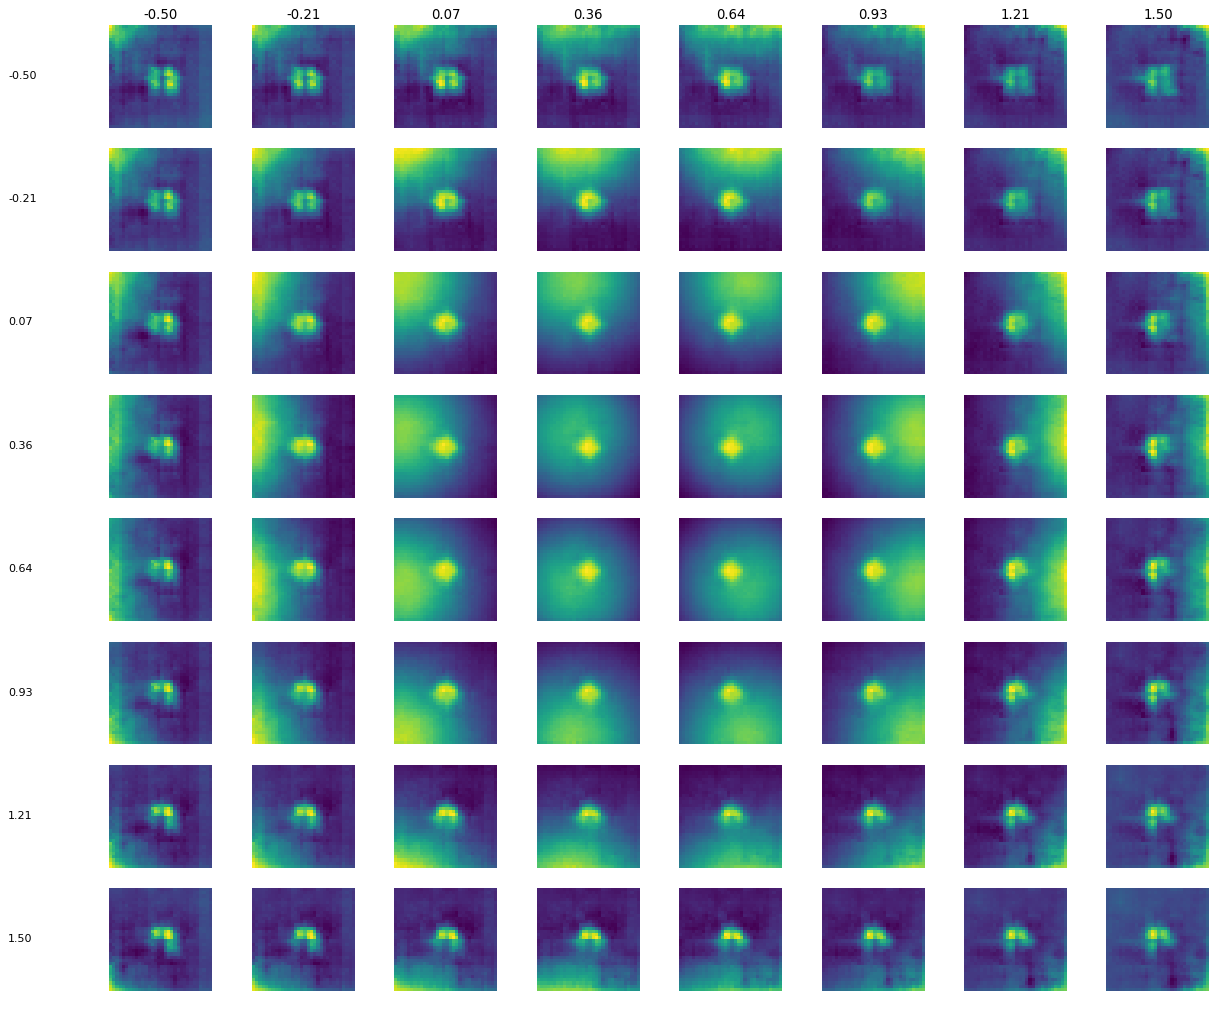

In [14]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

latents = torch.Tensor(1,4).to(device)
latents[0, :2] = torch.Tensor([.5, .5])
for ii in range(n_grid):
    for jj in range(n_grid):
        latents[0, 2:] = torch.Tensor([xv[ii,jj], yv[ii,jj]])
        
        plt.subplot(n_grid, n_grid, ii*n_grid + jj + 1)
        plt.imshow(model(latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        if ii == 0:
            plt.title('%0.2f' % y[jj])
        if jj == 0:
            plt.text(-32, 16, '%0.2f' % x[ii])      

### Moving the center of the circle object

The decoder seems to have learned to move the foreground circle object.

Beyond the training range, it still wants to place the object 'energy' somewhere (instaed of no output).

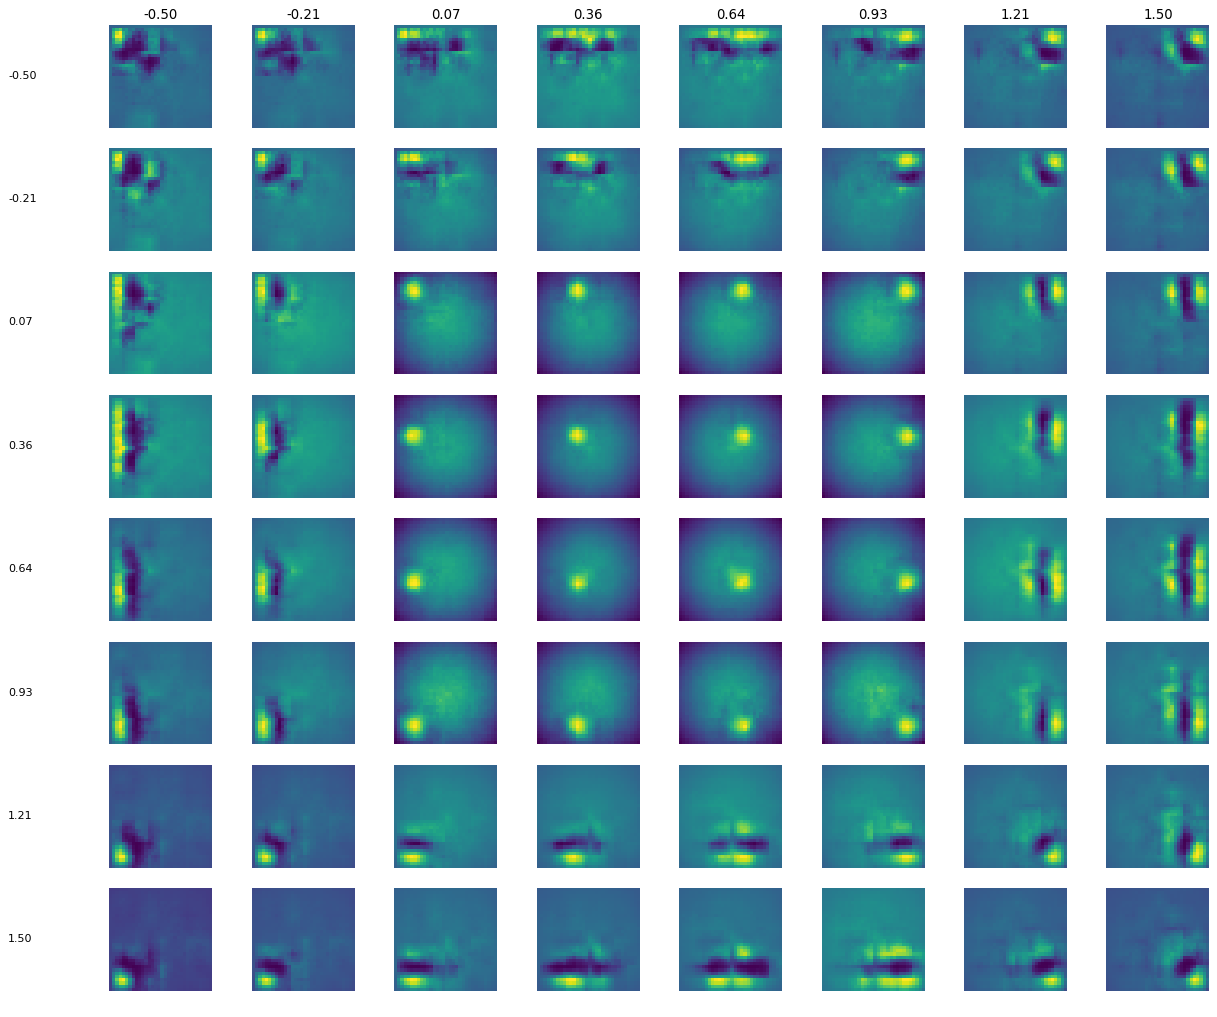

In [15]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

latents = torch.Tensor(1,4).to(device)
latents[0, 2:] = torch.Tensor([.5, .5])
for ii in range(n_grid):
    for jj in range(n_grid):
        latents[0, :2] = torch.Tensor([xv[ii,jj], yv[ii,jj]])
        
        plt.subplot(n_grid, n_grid, ii*n_grid + jj + 1)
        plt.imshow(model(latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        if ii == 0:
            plt.title('%0.2f' % y[jj])
        if jj == 0:
            plt.text(-32, 16, '%0.2f' % x[ii])

#### more finegrained object motion

Diagonal traversal across image space.

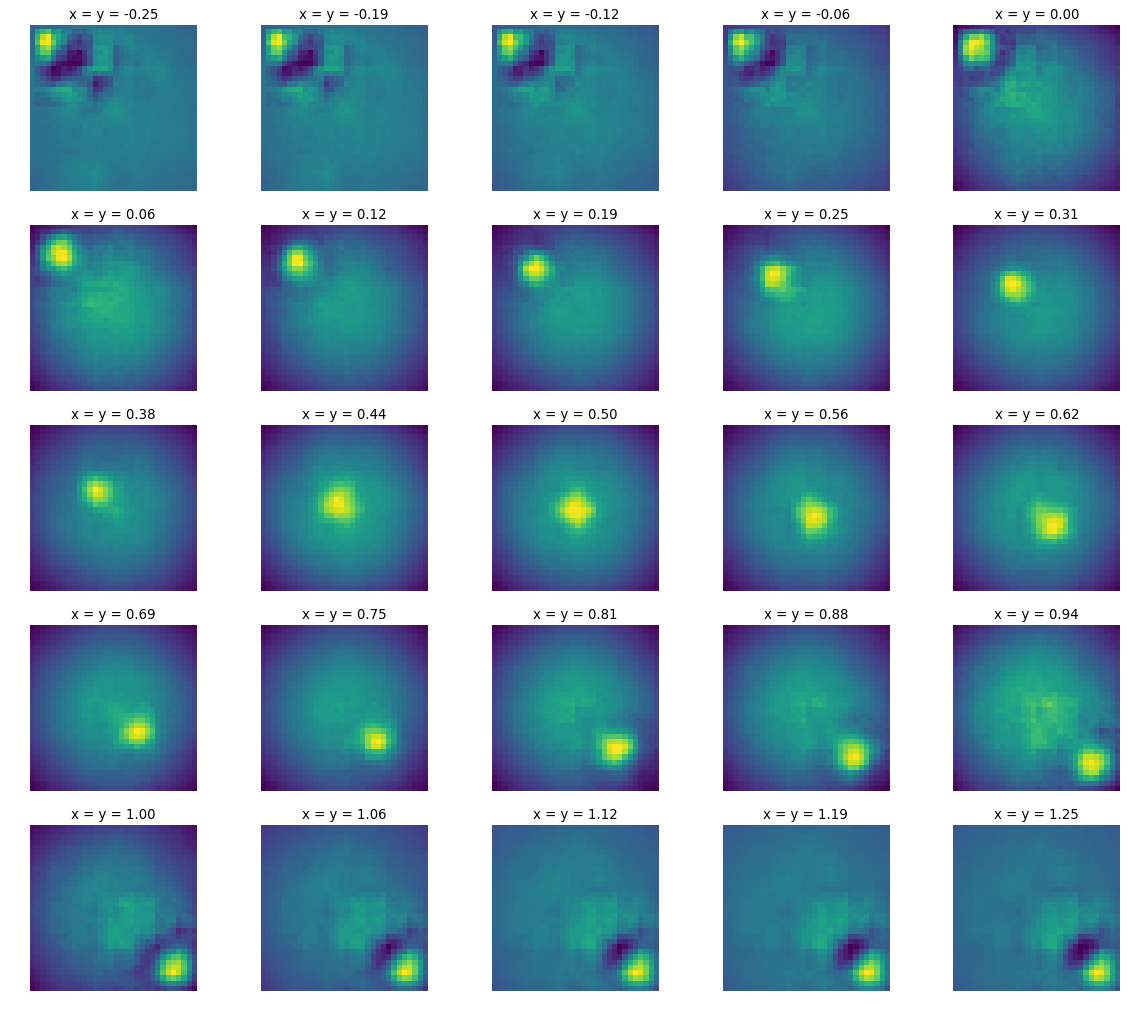

In [22]:
x2 = np.linspace(-.25, 1.25, 25)
y2 = np.linspace(-.25, 1.25, 25)


fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')


latents = torch.Tensor(1,4).to(device)
latents[0, 2:] = torch.Tensor([.5, .5])

for ii in range(len(x2)):
        latents[0, :2] = torch.Tensor([x2[ii], y2[ii]])
        
        plt.subplot(5, 5, ii + 1)
        plt.imshow(model(latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        plt.title('x = y = %0.2f' % x2[ii])

## Summary

Training seems generally successful.


Observations:

- When looking at .88 and .94, it seems like the latens of the circle and the background are not fully independent (yet) as the Gaussian blob is changing it's appearance. This might however be only training-related (not fully converged yet).


- a desired result for the circle object would be that the circle would disappear once the x,y coordinates of the circle are outside [0,1]. For the gaussian blob, something like this seems to happen. However, gaussian blob and circle are consistently different during training. Namely, the 'energy' in image space varies for the Gaussian blob during training. The circle however is always present during training - hence, there is no reason for the network to learn an only partially (or fully not) present circle. Training with partial/full occlusion will likely help there. Or more easily here: training with coordinates beyond [0,1] (where no circle is present).